In [1]:
%run /Users/pnl0rc8b@emea.royalahold.net/Functions_Rebuild

In [2]:
%run /Users/pnl0rc8b@emea.royalahold.net/Functions_Formateren

In [3]:
ATTRIBUUT = "ndTypeOfGrain" # Selecteer Attribuut
Classes_threshold = 11
Overig_threshold = 300 # Class beneden deze threshold, zal worden toegevoegd aan class: 'overig'

Multi_label = False

numerieke_features = ['FIBER']

# Fix empty rows

In [5]:
nd_controle = koppel_ndAttributen()
df_geformateerd, multi_label_flag,classes_available = create_overige_class(nd_controle, ATTRIBUUT,Classes_threshold, Overig_threshold)

DF_merged = koppel_preprocessed_text(df_geformateerd)
DF_merged = fix_empty_fields(DF_merged, ATTRIBUUT)

Amount of rows: (33197, 'Amount of columns: ', 134)
ATTRIBUUT: ndTypeOfGrain
Kleine classes die onder overige moeten: ['Amarant', 'Boekweit', 'Bulgur', 'Durum', 'Eenkoorn', 'Emmer', 'Freekeh', 'Gierst', 'Kamut', 'Quinoa', 'Sorghum', 'Spelt', 'Teff']
Grotere classes: ['EMPTY', 'Gerst', 'Haver', 'Mais', 'Rijst', 'Rogge', 'Tarwe']
null entries = 0
Shape van dataframe: (23424, 33)
null entries = 1675

<BarContainer object of 9 artists> <class 'matplotlib.container.BarContainer'>

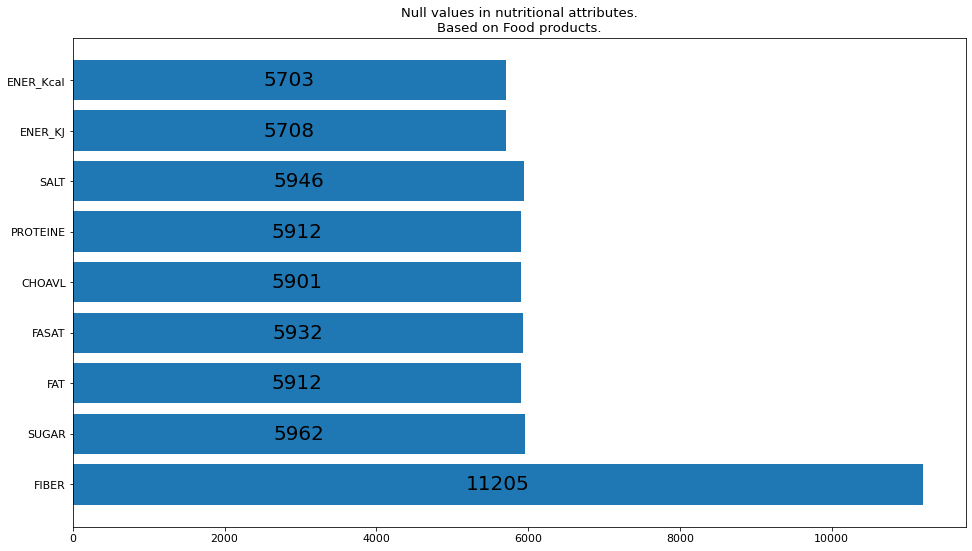

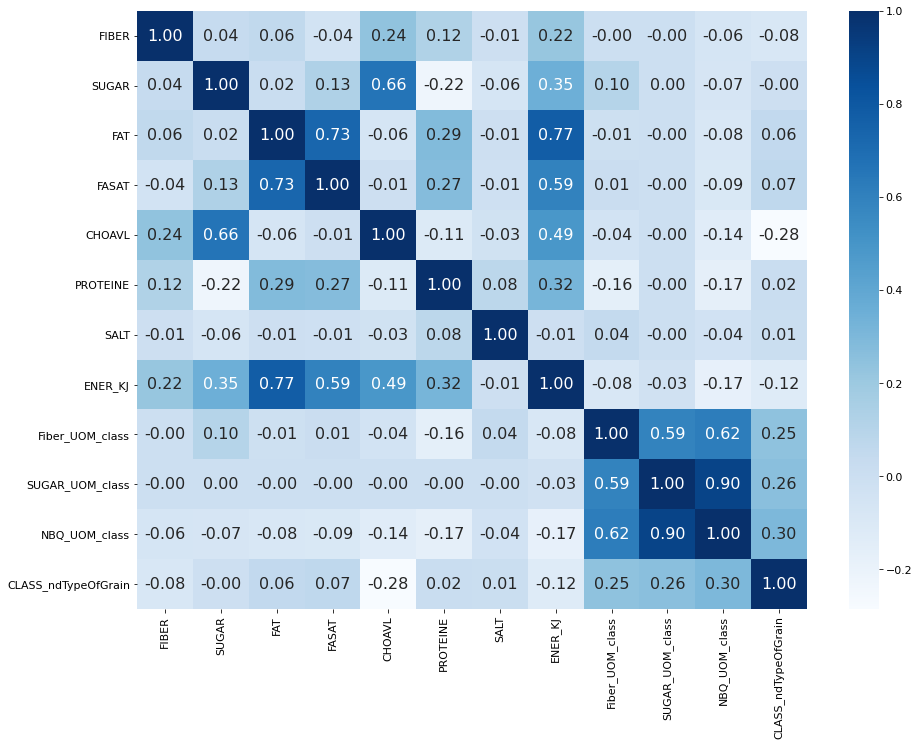

In [6]:
DF_merged = Correlation_matrix(DF_merged, ATTRIBUUT)

# Load models from database, ndTypeOfGrain exists out of multiple models.

In [8]:
TARGETS = DF_merged['class_names_'+ATTRIBUUT].tolist()
TARGETS = TARGETS[0]
print(TARGETS)

numerical, text, target_unused, vocab_size_unused = single_prep_controle(numerieke_features, DF_merged, ATTRIBUUT)

['EMPTY', 'Gerst', 'Haver', 'Mais', 'Rijst', 'Rogge', 'Tarwe', 'overig']
Vocabular size: 41228.0
Numerical Features: Index(['FIBER'], dtype='object')
Shape Numerical Features: (21749, 1)
Shape Text Features: (21749, 301)
Shape Targets: (21749, 8, 2)

In [9]:

from tensorflow import keras
all_model_files = dbutils.fs.ls("dbfs:/FileStore/nd_MODELS_publicatie/"+str(ATTRIBUUT))
#print(all_model_files)
controle_tabel = DF_merged[['gtin','gln','Lemmatized',ATTRIBUUT]]
total_pred = []
total_test = []
class_names = []

for index, model in enumerate(all_model_files): # loop through all models
    print(model.path)
    dbutils.fs.cp(model.path, "file:/FileStore/nd_MODELS_publicatie/"+str(ATTRIBUUT)+"/"+model.name)
    model = keras.models.load_model("/FileStore/nd_MODELS_publicatie/"+str(ATTRIBUUT)+"/"+model.name)

    # TARGET
    target = TARGETS[index]
    print(target)
    
    y_target = DF_merged[str(target)].tolist()
    y_target_tensor = torch.FloatTensor(y_target)
    y_target = y_target_tensor.numpy()
    print(numerical.shape, text.shape, y_target.shape)

    # Predictions
    list_ytest, list_yhat, yhat2 = predictions_2inputs(model, numerical, text, y_target)
    
    controle_tabel['TRUE '+str(target)] = list_ytest
    controle_tabel['PRED '+str(target)] = list_yhat
    total_test.append(list_ytest)
    total_pred.append(list_yhat)
    class_names.append(target)

dbfs:/FileStore/nd_MODELS_publicatie/ndTypeOfGrain/model_EMPTY.h5
EMPTY
(21749, 1) (21749, 301) (21749, 2)
 1/680 [..............................] - ETA: 1:49 29/680 [>.............................] - ETA: 1s  66/680 [=>............................] - ETA: 0s103/680 [===>..........................] - ETA: 0s132/680 [====>.........................] - ETA: 0s166/680 [======>.......................] - ETA: 0s200/680 [=======>......................] - ETA: 0s239/680 [=========>....................] - ETA: 0s279/680 [===========>..................] - ETA: 0s309/680 [============>.................] - ETA: 0s348/680 [==============>...............] - ETA: 0s387/680 [================>.............] - ETA: 0s425/680 [=================>............] - ETA: 0s464/680 [===================>..........] - ETA: 0s494/680 [====================>.........] - ETA: 0s532/680 [======================>.......] - ETA: 0s568/680 [========================>.....] - ETA: 0s607/680 [=========================>....] - ETA: 0s646/680 [===========================>..] - ETA: 0s680/680 [==============================] - 1s 1ms/step
 1/680 [..............................] - ETA: 2:02 - loss: 0.2584 - accuracy: 0.9688 35/680 [>.............................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9768  69/680 [==>...........................] - ETA: 0s - loss: 0.1023 - accuracy: 0.9751105/680 [===>..........................] - ETA: 0s - loss: 0.1049 - accuracy: 0.9738140/680 [=====>........................] - ETA: 0s - loss: 0.1117 - accuracy: 0.9721172/680 [======>.......................] - ETA: 0s - loss: 0.1089 - accuracy: 0.9726207/680 [========>.....................] - ETA: 0s - loss: 0.1111 - accuracy: 0.9719241/680 [=========>....................] - ETA: 0s - loss: 0.1116 - accuracy: 0.9716277/680 [===========>..................] - ETA: 0s - loss: 0.1050 - accuracy: 0.9734311/680 [============>.................] - ETA: 0s - loss: 0.1054 - accuracy: 0.9729346/680 [==============>...............] - ETA: 0s - loss: 0.1070 - accuracy: 0.9729382/680 [===============>..............] - ETA: 0s

In [10]:
# TABLE predictions to the right format
total_test_T = np.array(total_test)
total_test_T = total_test_T.T
total_test_T = total_test_T.tolist()
total_pred_T = np.array(total_pred)
total_pred_T = total_pred_T.T
total_pred_T = total_pred_T.tolist()


# convert [0,0,0,0,0] into [1,0,0,0,0]
if ATTRIBUUT == 'ndAnimalSpecies':
    for index, row_pred in enumerate(total_pred_T):
        if row_pred == [0,0,0,0,0,0]:
            total_pred_T[index] = [0,1,0,0,0,0]
if ATTRIBUUT == 'ndTypeOfGrain':
    for index, row_pred in enumerate(total_pred_T):
        if row_pred == [0,0,0,0,0,0,0,0]:
            total_pred_T[index] = [1,0,0,0,0,0,0,0]
        
# Wanneer er empty + graan aanwezig is, verwijder dan empty. Alleen nodig bij multi-label models
prediction_new = []
for prediction in total_pred_T:
    if prediction.count(1) >1 and prediction[1]==1:
        prediction_cp = prediction
        prediction_cp[1] = 0
    else:
        prediction_cp = prediction
    prediction_new.append(prediction_cp)
    
controle_tabel['TRUE'] = total_test_T
controle_tabel['PREDICTED'] = prediction_new #total_pred_T
controle_tabel_T = controle_tabel[['gtin','gln','Lemmatized',ATTRIBUUT,'TRUE','PREDICTED']]

# Place labels in column
labels = DF_merged['class_names_'+ATTRIBUUT].tolist()
labels = labels[0]

total_labels = []
for row in controle_tabel_T['PREDICTED']:
    product_labels = []
    for index, label in enumerate(row):
        if label == 1:
            product_labels.append(labels[index])
    total_labels.append(product_labels)
controle_tabel_T['PREDICTED Labels'] = total_labels
controle_tabel_T.head()

Out[27]:

,gtin,gln,Lemmatized,ndTypeOfGrain,TRUE,PREDICTED,PREDICTED Labels
0,42399520,8710642000017,frisdrank sinaasappelsap suiker zoetstof limon...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
1,50112821,8710642000017,frisdrank plantenextract zoetstof cola zero su...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
2,54001909,8722800000012,banaan los chiquita banaan chiquita banaan to ...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
3,54003842,5400207999995,cigarette pall mall red49 sigaret pall mall re...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]",[EMPTY]
5,54018037,8725000000011,bier speciaalbier leff leff bruin 30cl speciaa...,EMPTY,"[1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0]",[Mais]


# Compare

## UNEQUAL table

In [13]:
UNEQUAL_TABLE = controle_tabel_T.loc[~(controle_tabel_T['TRUE'] == controle_tabel_T['PREDICTED'])]
EQUAL_TABLE = controle_tabel_T.loc[(controle_tabel_T['TRUE'] == controle_tabel_T['PREDICTED'])]
UNEQUAL_TABLE.drop(columns=['TRUE','PREDICTED'], axis=1, inplace=True)
EQUAL_TABLE.drop(columns=['TRUE','PREDICTED'], axis=1, inplace=True)

print(len(UNEQUAL_TABLE))
display(UNEQUAL_TABLE.head())

2542

gtin,gln,Lemmatized,ndTypeOfGrain,PREDICTED Labels
54018037,8725000000011,bier speciaalbier leff leff bruin 30cl speciaalbi ingrediënt water gerstemout mais gerst suiker hop,EMPTY,List(Mais)
54057197,8714252030303,speciaal bier bier cornet smoke cornet smoke 33cl bevatten gerstemout tarwemout,Gerst|Tarwe,List(Tarwe)
3116430057587,3116430000101,koek chocolade koek wafel biscuit delacre marquisette 175 g marquisette 175 g ingrediënt tarwebloem plantaardig vet palm raapzaad chocolade 175 cacaomassa suiker cacaoboter boterolie emulgator sojalecithin suiker lactose melkeiwitt heeleipoeder zout natuurlijk aroma spoor bevatten hazelnoot noot haver gerst glut,Gerst|Haver|Tarwe,"List(Haver, Tarwe)"
3116430058164,3116430000101,koekjesassortiment koek wafel biscuit delacre tea time 500 g tea time 500 g ingrediënt tarwebloem suiker melkchocolade 15 suiker cacaoboter cacaomassa mager melkpoeder boterolie emulgator sojalecithin aroma plantaardig vet palm raapzaad palmpit kokosnoot chocolade 12 suiker cacaomassa cacaoboter boterolie emulgator sojalecithin wit chocolade 5 suiker cacaoboter mager melkpoeder weipoeder boterolie emulgator sojalecithin aroma tarwezetmeel lactose melkeiwiten kokosnoot 08 dextrose mager cacaopoeder 03 chocoladevlok suiker cacaomassa cacaoboter vol melkpoeder boterolie aroma zout gerstemout bloem bruin suiker 01 boter amandel vollemelkpoe kippeneieiwitpoeder emulgator sojalecithin heeleipoed rijsmiddel natriumcarbonaten ammoniumcarbonat dinatrium difosfaat eigeelpoeder aroma kandijstroop spoor pecannoten noot hazelnoot haver glut bevatten,Gerst|Haver|Tarwe,"List(Haver, Tarwe)"
4001724015635,8710466000019,pizza dun bodem luchtig knapperig rand rijkelijk beleggen tomatensaus mozzarella edammer emmentaler blauwaderkaas diepvrie pizza dr oetker casa di mama quattro formaggi 410 gram dr oetker casa di mama quattro formaggi 410 gram ingrediënt tarwebloem water 10 zeven tomaat 74 mozzarella kaas 74 edammer kaas slagroom 52 tomatenconcentraat 29 emmentaler kaas bakkersgist palmvet suiker zout 06 blauwschimmelkaas basilicum voedingszur calciumfosfat calciumcitrat gerstemoutextract raapzaadolie rijsmiddel natriumwaterstofcarbonaat emulgator mono diglycerid vetzuur veresteren mono diacetylwijnsteenzuur verdikkingsmiddel guarpitmeel modificeren zetmeel dextrose oregano specerij geschikt vegetariër gebruiken kaas bevatten vegetarisch stremsel,Gerst|Tarwe,List(Tarwe)


## EQUAL table

In [15]:
display(EQUAL_TABLE.head())

gtin,gln,Lemmatized,ndTypeOfGrain,PREDICTED Labels
42399520,8710642000017,frisdrank sinaasappelsap suiker zoetstof limonade orange fanta orange fanta orange pet 0375l 1x ingrediënt sprankelen water sinaasappelsap concentraat 65 suiker voedingszur citroenzuur appelzuur natriumcitrat natuurlijk sinaasappelaroma ’s natuurlijk aroma ’s zoetstof natriumcyclamaat acesulfaamk sucralose conserveermiddel kaliumsorbaat antioxidant ascorbinezuur wortelconcentraat stabilisator guarpitmeel kleurstof caroten,EMPTY,List(EMPTY)
50112821,8710642000017,frisdrank plantenextract zoetstof cola zero sugar cocacola zero cocacola zero pet 0375l 1x ingrediënt sprankelen water kleurstof e150d voedingszuren e338 e331 zoetstof aspartaam acesulfaamk natuurlijk aroma plantenextract waaronder cafeïne,EMPTY,List(EMPTY)
54001909,8722800000012,banaan los chiquita banaan chiquita banaan to go pst,EMPTY,List(EMPTY)
54003842,5400207999995,cigarette pall mall red49 sigaret pall mall red49 pall mall red49,EMPTY,List(EMPTY)
54018204,8725000000011,onfilteren bier verfijnen krachtig toets speciaalbier leff leff tripel 30cl speciaalbier ingrediënt water gerstemout suiker kruid natuurlijk sinaasappelschil korianderzad hop,Gerst,List(Gerst)
